In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


# preparing data

In [ ]:
%cd "drive/MyDrive/Pattern_P4/miniimagenet/splits/ravi-larochelle"

/content/drive/MyDrive/Pattern_P4/miniimagenet/splits/ravi-larochelle


In [ ]:
def read_file(filename):
    with open(filename) as f:
        lines = [line.replace('\n', '') for line in f]
    return lines

In [ ]:
C_train = read_file("train.txt")
C_val = read_file("val.txt")
C_test = read_file("test.txt")

In [ ]:
cd ..

/content/drive/MyDrive/Pattern_P4/miniimagenet/splits


In [ ]:
cd ..

/content/drive/MyDrive/Pattern_P4/miniimagenet


In [ ]:
cd data

/content/drive/MyDrive/Pattern_P4/miniimagenet/data


# Reading Images and Creating Tasks

In [ ]:
import random
import cv2
import os
from torch.optim import Optimizer
from torch.nn import Module
from torch.utils.data import DataLoader
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

In [ ]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

def load_image_name_from_folder(folder):
    images = [filename for filename in os.listdir(folder)]
    return images

def load_images_from_folder(folder):

    images = []
    for filename in os.listdir(folder):
        images.append(transform(Image.open(os.path.join(folder,filename))).unsqueeze(0))
    images = torch.cat(images, 0)

    return images

def load_images_of_list_from_folder(folder, proper):
    
    images = []
    for filename in os.listdir(folder):
        if filename in proper:
            images.append(transform(Image.open(os.path.join(folder,filename))).unsqueeze(0))
    
    return images

In [ ]:
def task_batch_creator(C_train, n_way, N, Q, batch_size):
    """
    Creates a batch of tasks
    input:
        train classes, 
        number of classes, 
        number of training shots, 
        number of test shots,
        batch size
    
    output:
        list of tasks (len(list) = batch_size), each task is a tuple of(support, query)
    """

    T = []
    for batch_idx in range(batch_size):
        Ci = random.sample(C_train, n_way) 

        support, query, x_train, y_train, x_test, y_test = [], [], [], [], [], []

        for j in range(len(Ci)):
            images = load_image_name_from_folder(Ci[j])
            # support and query shouldn't have intersection
            # so sample both of them at once, then split
            tmp = random.sample(images, N + Q)
            s = load_images_of_list_from_folder(folder = Ci[j], proper = tmp)
            
            x_train += s[:N] 
            x_test += s[N:]

            y_train += [j for i in range(N)]
            y_test += [j for i in range(Q)] 

        x_train = torch.cat(x_train, 0)
        x_test = torch.cat(x_test, 0)

        y_train = torch.LongTensor(np.array(y_train))
        y_test = torch.LongTensor(np.array(y_test))

        # shuffle both train and test set
        rearranged_train = random.sample(range(x_train.shape[0]), x_train.shape[0])
        x_train = x_train[rearranged_train]
        y_train = y_train[rearranged_train]

        rearranged_test = random.sample(range(x_test.shape[0]), x_test.shape[0])
        x_test = x_test[rearranged_test]
        y_test = y_test[rearranged_test]

        # generate support and query
        support = (x_train, y_train)
        query = (x_test, y_test)
        
        T.append((support, query))

    return T

# MAML

## 5 way - 1 shot

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def calculate_accuracy_f1(y, y_hat):
    p = y_hat.max(1, keepdim=True)[1]
    accuracy  = accuracy_score(y.cpu(), p.cpu())
    f1 = f1_score(y.cpu(), p.cpu(), average='macro')
    return accuracy, f1


In [ ]:
def create_model(number_of_classes):
    """
    Create a CNN model with a classification layer in the end.
    Last layer output neurons count is number_of_classes.
    """
    model = nn.Sequential(
                            nn.Conv2d(3, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),
                            
                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Flatten(),
                            nn.Linear(288, number_of_classes)
                            )
    return model

In [ ]:
# define hyperparameters

nway = 5
support_samples = 1
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
meta_model = create_model(nway)

In [ ]:
def train_inner_model(model, task, inner_epochs, device, inner_lr):
    criterion = nn.CrossEntropyLoss()
    inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)

    (x_train, y_train), (x_test, y_test) = task
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    
    model.train()
    for i in range(inner_epochs):
        inner_optimizer.zero_grad()
        train_prediction = model(x_train)
        inner_loss = criterion(train_prediction, y_train)
        inner_loss.backward()
        inner_optimizer.step()
    
    inner_optimizer.zero_grad()
    test_prediction = model(x_test)
    test_loss = criterion(test_prediction, y_test)

    test_loss.backward(retain_graph=True)
    test_loss.backward()

    grads = []
    for param in list(model.parameters()):
        grads.append(param.grad)

    loss = test_loss.item()
    acc, f1_score = calculate_accuracy_f1(y_test, test_prediction)
    
    return loss, grads, acc, f1_score    

In [ ]:
def train_meta_model(meta_model, outer_lr, meta_batch_size, device, inner_models_grads, inner_models_losses, inner_models_accuracies, inner_models_f1_scores):
    with torch.no_grad():
        meta_model.to(device)
        meta_model_grads = [torch.zeros_like(param) for param in inner_models_grads[0]] 
        
        # update meta model gradients based on inner model grads
        for base_model_grads in inner_models_grads:
            for grad_index in range(len(base_model_grads)):
                base_model_grad = base_model_grads[grad_index]
                meta_model_grads[grad_index] += (1/meta_batch_size) * base_model_grad

        # update meta model parameters
        for parameter, grad in zip(meta_model.parameters(), meta_model_grads):
            parameter.copy_(parameter - outer_lr * grad)
        
    meta_accuracy = sum(inner_models_accuracies) / meta_batch_size
    meta_f1 = sum(inner_models_f1_scores) / meta_batch_size
    meta_loss = sum(inner_models_losses) / meta_batch_size 

    return meta_model, meta_loss, meta_accuracy, meta_f1
    

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])
    
    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.5627651810646057, accuracy = 0.27, f1 = 0.26429900833637876
Epoch 100: loss = 1.555088758468628, accuracy = 0.32, f1 = 0.2942038854267283
Epoch 150: loss = 1.5895367562770844, accuracy = 0.255, f1 = 0.2460723176931408
Epoch 200: loss = 1.381275236606598, accuracy = 0.425, f1 = 0.40470375011351195
Testing ****** Epoch 200: loss = 1.5937779784202575, acc = 0.29799999999999993, f1 = 0.28561508904249056
Epoch 250: loss = 1.5268358886241913, accuracy = 0.295, f1 = 0.24967695589434719
Epoch 300: loss = 1.5277510285377502, accuracy = 0.33, f1 = 0.30065278301710935
Epoch 350: loss = 1.5332510471343994, accuracy = 0.315, f1 = 0.2857015076763024
Epoch 400: loss = 1.5430622696876526, accuracy = 0.31000000000000005, f1 = 0.3034947028505153
Testing ****** Epoch 400: loss = 1.5730413258075715, acc = 0.28400000000000003, f1 = 0.26546442697309575
Epoch 450: loss = 1.4967824816703796, accuracy = 0.38, f1 = 0.36868721659877945
Epoch 500: loss = 1.5440469682216644, accuracy = 0.2950000

### Results

Text(0.5, 1.0, 'Train Loss')

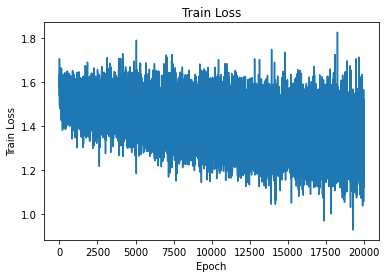

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot(meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

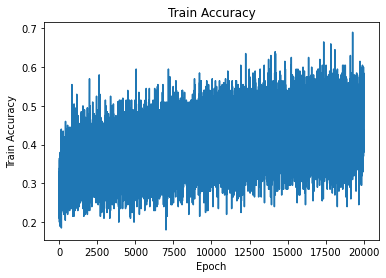

In [ ]:
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot(meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train F1-Score')

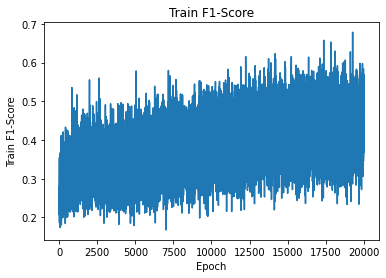

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot(meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

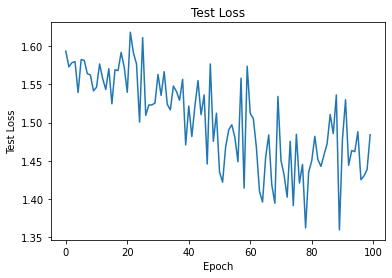

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot(meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

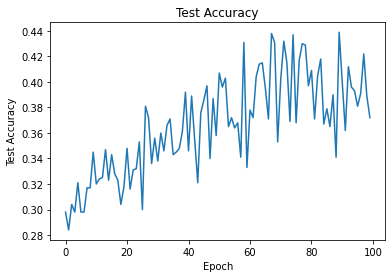

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot(meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

## 5 way - 5 shot

In [ ]:
nway = 5
support_samples = 5
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])
    
    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.4639405608177185, accuracy = 0.39, f1 = 0.38575363776753596
Epoch 100: loss = 1.4776631295681, accuracy = 0.395, f1 = 0.3880015908658727
Epoch 150: loss = 1.362838238477707, accuracy = 0.45499999999999996, f1 = 0.44482113033364884
Epoch 200: loss = 1.5480298399925232, accuracy = 0.36500000000000005, f1 = 0.3553649855476481
Testing ****** Epoch 200: loss = 1.4270182251930237, acc = 0.403, f1 = 0.3982844804926108
Epoch 250: loss = 1.4482207298278809, accuracy = 0.37, f1 = 0.3547571670301849
Epoch 300: loss = 1.3143972605466843, accuracy = 0.435, f1 = 0.423615401794329
Epoch 350: loss = 1.229069173336029, accuracy = 0.515, f1 = 0.5045040885327263
Epoch 400: loss = 1.357643187046051, accuracy = 0.41999999999999993, f1 = 0.4216001352162343
Testing ****** Epoch 400: loss = 1.3959240853786468, acc = 0.42800000000000005, f1 = 0.4232358147984141
Epoch 450: loss = 1.3345209062099457, accuracy = 0.44500000000000006, f1 = 0.4354477827813741
Epoch 500: loss = 1.327710598707199, a

### Results

Text(0.5, 1.0, 'Train Loss')

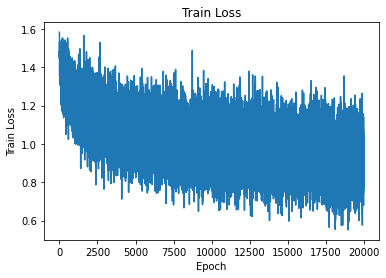

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot(meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train Accuracy')

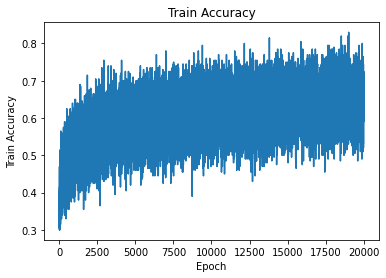

In [ ]:
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot(meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train F1-Score')

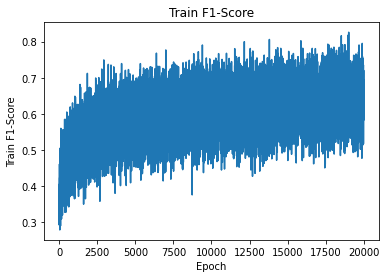

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot(meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

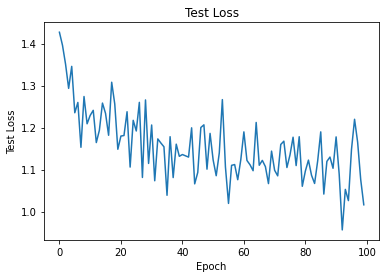

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot(meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

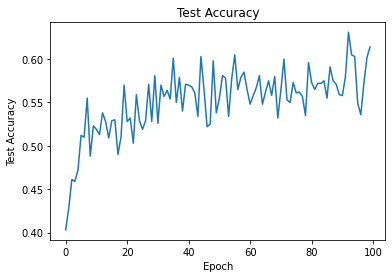

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot(meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

# FOMAML

## 5 way - 1 shot

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def calculate_accuracy_f1(y, y_hat):
    p = y_hat.max(1, keepdim=True)[1]
    accuracy  = accuracy_score(y.cpu(), p.cpu())
    f1 = f1_score(y.cpu(), p.cpu(), average='macro')
    return accuracy, f1


In [ ]:
def create_model(number_of_classes):
    """
    Create a CNN model with a classification layer in the end.
    Last layer output neurons count is number_of_classes.
    """
    model = nn.Sequential(
                            nn.Conv2d(3, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),
                            
                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Conv2d(32, 32, (3,3), (1,1)),
                            nn.BatchNorm2d(32),
                            nn.ReLU(),
                            nn.MaxPool2d((2,2)),

                            nn.Flatten(),
                            nn.Linear(288, number_of_classes)
                            )
    return model

In [ ]:
nway = 5
support_samples = 1
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
meta_model = create_model(nway)

In [ ]:
def train_inner_model(model, task, inner_epochs, device, inner_lr):
    criterion = nn.CrossEntropyLoss()
    inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)

    (x_train, y_train), (x_test, y_test) = task
    x_train, y_train = x_train.to(device), y_train.to(device)
    x_test, y_test = x_test.to(device), y_test.to(device)
    
    model.train()
    for i in range(inner_epochs):
        inner_optimizer.zero_grad()
        train_prediction = model(x_train)
        inner_loss = criterion(train_prediction, y_train)
        inner_loss.backward()
        inner_optimizer.step()
    
    inner_optimizer.zero_grad()
    test_prediction = model(x_test)
    test_loss = criterion(test_prediction, y_test)

    # only this part is different from MAML
    test_loss.backward()

    grads = []
    for param in list(model.parameters()):
        grads.append(param.grad)

    loss = test_loss.item()
    acc, f1_score = calculate_accuracy_f1(y_test, test_prediction)
    
    return loss, grads, acc, f1_score    

In [ ]:
def train_meta_model(meta_model, outer_lr, meta_batch_size, device, inner_models_grads, inner_models_losses, inner_models_accuracies, inner_models_f1_scores):
    with torch.no_grad():
        meta_model.to(device)
        meta_model_grads = [torch.zeros_like(param) for param in inner_models_grads[0]] 
        
        # update meta model gradients based on inner model grads
        for base_model_grads in inner_models_grads:
            for grad_index in range(len(base_model_grads)):
                base_model_grad = base_model_grads[grad_index]
                meta_model_grads[grad_index] += (1/meta_batch_size) * base_model_grad

        # update meta model parameters
        for parameter, grad in zip(meta_model.parameters(), meta_model_grads):
            parameter.copy_(parameter - outer_lr * grad)
        
    meta_accuracy = sum(inner_models_accuracies) / meta_batch_size
    meta_f1 = sum(inner_models_f1_scores) / meta_batch_size
    meta_loss = sum(inner_models_losses) / meta_batch_size 

    return meta_model, meta_loss, meta_accuracy, meta_f1
    

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])
    
    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')

Epoch 50: loss = 1.6328255534172058, accuracy = 0.25, f1 = 0.24451491188787017
Epoch 100: loss = 1.578827053308487, accuracy = 0.28500000000000003, f1 = 0.27015138589791976
Epoch 150: loss = 1.5636222660541534, accuracy = 0.3, f1 = 0.28866975013589635
Epoch 200: loss = 1.5421617031097412, accuracy = 0.305, f1 = 0.2983640630668494
Testing ****** Epoch 200: loss = 1.6090845882892608, acc = 0.269, f1 = 0.24048905685288383
Epoch 250: loss = 1.5233589112758636, accuracy = 0.34500000000000003, f1 = 0.3420737985784425
Epoch 300: loss = 1.6044201850891113, accuracy = 0.255, f1 = 0.24602721184682133
Epoch 350: loss = 1.5210363566875458, accuracy = 0.315, f1 = 0.28189359356760757
Epoch 400: loss = 1.5467495322227478, accuracy = 0.3, f1 = 0.27678793941311286
Testing ****** Epoch 400: loss = 1.5942289888858796, acc = 0.298, f1 = 0.2780822947432019
Epoch 450: loss = 1.522959053516388, accuracy = 0.305, f1 = 0.28686174765777883
Epoch 500: loss = 1.5031494796276093, accuracy = 0.375, f1 = 0.344494607

### results

Text(0.5, 1.0, 'Train Accuracy')

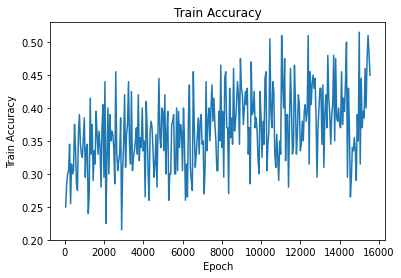

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

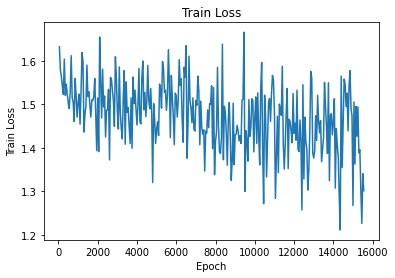

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

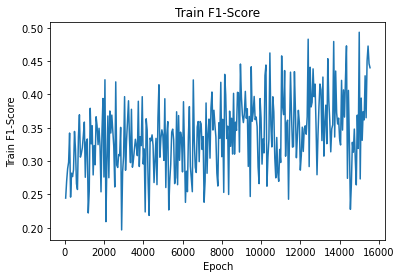

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

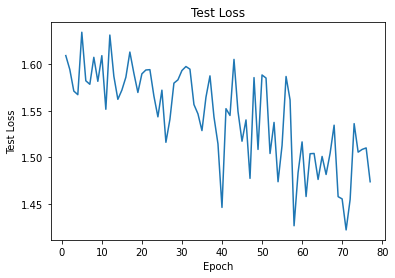

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

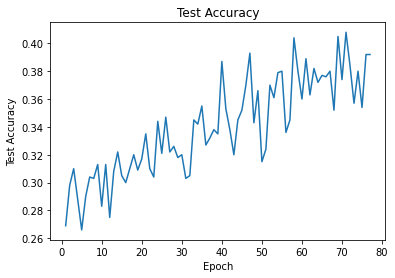

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

## 5 way - 5 shot

In [ ]:
nway = 5
support_samples = 5
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])
    
    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.4521698951721191, accuracy = 0.365, f1 = 0.34992712224136374
Epoch 100: loss = 1.4650860130786896, accuracy = 0.4, f1 = 0.3910213058355473
Epoch 150: loss = 1.2997801005840302, accuracy = 0.535, f1 = 0.5247041691650656
Epoch 200: loss = 1.4111467003822327, accuracy = 0.41000000000000003, f1 = 0.40933181613259684
Testing ****** Epoch 200: loss = 1.4974956691265107, acc = 0.3690000000000001, f1 = 0.363953278855722
Epoch 250: loss = 1.3751482367515564, accuracy = 0.45000000000000007, f1 = 0.4335025141970895
Epoch 300: loss = 1.4260573089122772, accuracy = 0.395, f1 = 0.3835575539348255
Epoch 350: loss = 1.2556096613407135, accuracy = 0.49, f1 = 0.4825479257995411
Epoch 400: loss = 1.30748650431633, accuracy = 0.475, f1 = 0.4696902121225718
Testing ****** Epoch 400: loss = 1.368661367893219, acc = 0.42000000000000004, f1 = 0.4127248827734088
Epoch 450: loss = 1.3185020685195923, accuracy = 0.48500000000000004, f1 = 0.47510515588941354
Epoch 500: loss = 1.227393090724945,

### results

Text(0.5, 1.0, 'Train Accuracy')

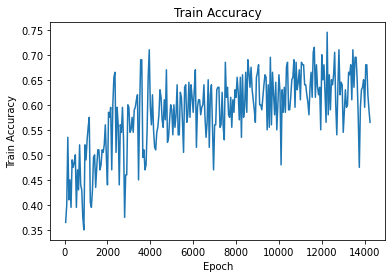

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

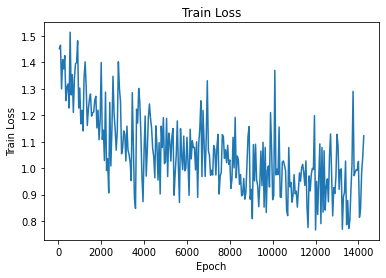

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

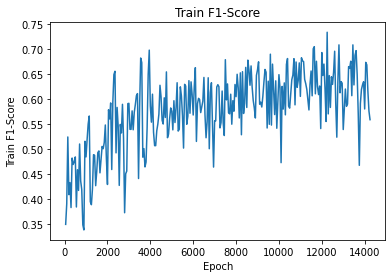

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

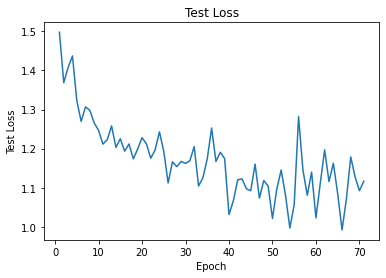

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

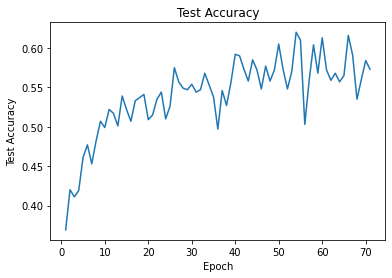

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

# Q3

## MAML

### 5 way - 1 shot

In [ ]:
nway = 5
support_samples = 1
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
meta_model = create_model(nway)

In [ ]:
def train_inner_model(model, task, inner_epochs, device, inner_lr):
    criterion = nn.CrossEntropyLoss()
    inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)
    
    # this part is different from Q1 and Q2
    (whole_x_train, whole_y_train), (x_test, y_test) = task[0], task[1]
    desired = whole_x_train.shape[0]//inner_epochs
    x_test, y_test = x_test.to(device), y_test.to(device)

    model.train()
    for i in range(inner_epochs):
        x_train = whole_x_train[i * desired : (i + 1) * desired]
        y_train = whole_y_train[i * desired : (i + 1) * desired]
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        inner_optimizer.zero_grad()
        train_prediction = model(x_train)
        inner_loss = criterion(train_prediction, y_train)
        inner_loss.backward()
        inner_optimizer.step()
    
    model.train()
    inner_optimizer.zero_grad()
    test_prediction = model(x_test)
    test_loss = criterion(test_prediction, y_test)

    test_loss.backward(retain_graph=True)
    test_loss.backward()

    grads = []
    for param in list(model.parameters()):
        grads.append(param.grad)

    loss = test_loss.item()

    acc, f1_score = calculate_accuracy_f1(y_test, test_prediction)
    
    return loss, grads, acc, f1_score
    

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples*inner_epochs_train, Q=query_samples, meta_batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])

    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples*inner_epochs_test, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.5845155119895935, accuracy = 0.32000000000000006, f1 = 0.28439562426774706
Epoch 100: loss = 1.5260429978370667, accuracy = 0.35, f1 = 0.313514396835049
Epoch 150: loss = 1.4848920106887817, accuracy = 0.35000000000000003, f1 = 0.30726653836626344
Epoch 200: loss = 1.352016419172287, accuracy = 0.41500000000000004, f1 = 0.3964422130393997
Testing ****** Epoch 200: loss = 1.4490661799907685, acc = 0.387, f1 = 0.35944533197080697
Epoch 250: loss = 1.4721518754959106, accuracy = 0.36, f1 = 0.3290865017058465
Epoch 300: loss = 1.4153395891189575, accuracy = 0.41500000000000004, f1 = 0.3923712114824647
Epoch 350: loss = 1.479868322610855, accuracy = 0.335, f1 = 0.325679391835617
Epoch 400: loss = 1.3840928673744202, accuracy = 0.415, f1 = 0.3863574154366993
Testing ****** Epoch 400: loss = 1.3999247789382934, acc = 0.4040000000000001, f1 = 0.3748296696315091
Epoch 450: loss = 1.2301366329193115, accuracy = 0.525, f1 = 0.49541146357072374
Epoch 500: loss = 1.39719304442405

#### results

Text(0.5, 1.0, 'Train Accuracy')

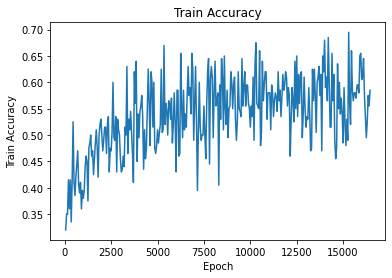

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

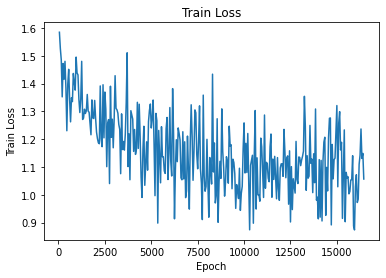

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

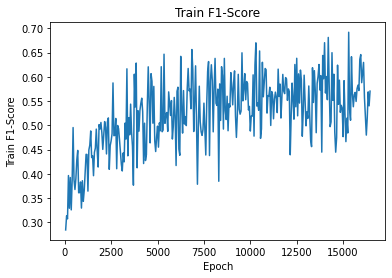

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

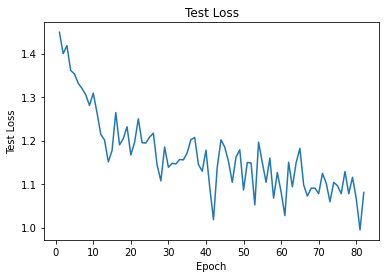

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

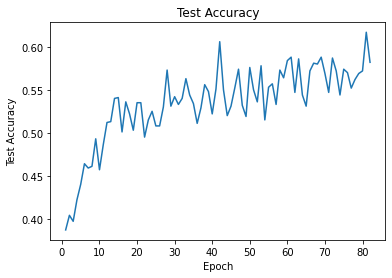

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

### 5 way - 5 shot

In [ ]:
nway = 5
support_samples = 5
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train = C_train, n_way = nway, N = support_samples * inner_epochs_train, Q = query_samples, meta_batch_size = meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])

    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples*inner_epochs_test, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.396290510892868, accuracy = 0.405, f1 = 0.4006536028321598
Epoch 100: loss = 1.2368435263633728, accuracy = 0.5, f1 = 0.4527047984351631
Epoch 150: loss = 1.2651202380657196, accuracy = 0.485, f1 = 0.4612180244975592
Epoch 200: loss = 1.2816570699214935, accuracy = 0.465, f1 = 0.45564422356184364
Testing ****** Epoch 200: loss = 1.2888451874256135, acc = 0.485, f1 = 0.48018024363077527
Epoch 250: loss = 1.1804150342941284, accuracy = 0.535, f1 = 0.5100166478314614
Epoch 300: loss = 1.2918538302183151, accuracy = 0.485, f1 = 0.46373037084286917
Epoch 350: loss = 1.1368875801563263, accuracy = 0.555, f1 = 0.5476016109793199
Epoch 400: loss = 1.2608017921447754, accuracy = 0.5, f1 = 0.49225574431052965
Testing ****** Epoch 400: loss = 1.2226291388273238, acc = 0.5, f1 = 0.4851505269981712
Epoch 450: loss = 1.2157593369483948, accuracy = 0.52, f1 = 0.5050267812421197
Epoch 500: loss = 1.3125763833522797, accuracy = 0.485, f1 = 0.4695797393766501
Epoch 550: loss = 1.07316

#### results

Text(0.5, 1.0, 'Train Accuracy')

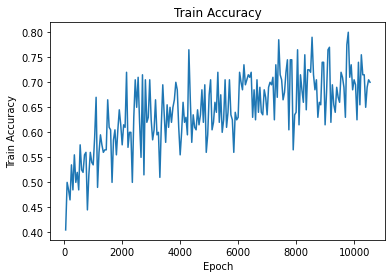

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

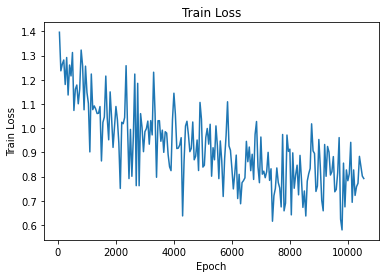

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

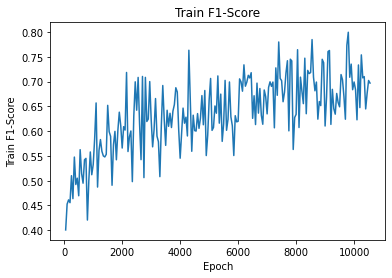

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

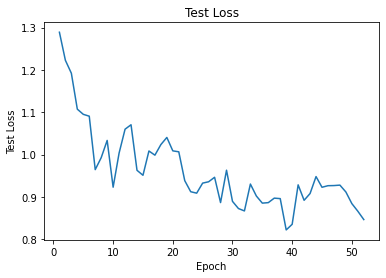

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

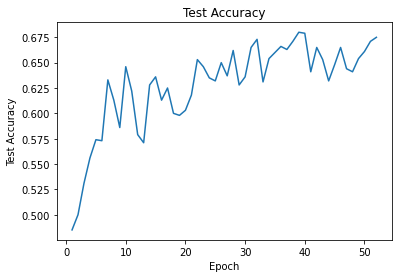

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

## FOMAML

### 5 way - 1 shot

In [ ]:
nway = 5
support_samples = 1
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
meta_model = create_model(nway)

In [ ]:
def train_inner_model(model, task, inner_epochs, device, inner_lr):
    criterion = nn.CrossEntropyLoss()
    inner_optimizer = optim.SGD(model.parameters(), lr=inner_lr)
    
    (whole_x_train, whole_y_train), (x_test, y_test) = task[0], task[1]
    desired = whole_x_train.shape[0]//inner_epochs
    x_test, y_test = x_test.to(device), y_test.to(device)

    model.train()
    for i in range(inner_epochs):
        x_train = whole_x_train[i * desired : (i + 1) * desired]
        y_train = whole_y_train[i * desired : (i + 1) * desired]
        x_train, y_train = x_train.to(device), y_train.to(device)
        
        inner_optimizer.zero_grad()
        train_prediction = model(x_train)
        inner_loss = criterion(train_prediction, y_train)
        inner_loss.backward()
        inner_optimizer.step()
    
    model.train()
    inner_optimizer.zero_grad()
    test_prediction = model(x_test)
    test_loss = criterion(test_prediction, y_test)

    test_loss.backward()

    grads = []
    for param in list(model.parameters()):
        grads.append(param.grad)

    loss = test_loss.item()

    acc, f1_score = calculate_accuracy_f1(y_test, test_prediction)
    
    return loss, grads, acc, f1_score

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train = C_train, n_way = nway, N = support_samples * inner_epochs_train, Q = query_samples, meta_batch_size = meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])

    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples*inner_epochs_test, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.503521889448166, accuracy = 0.355, f1 = 0.33973134115020986
Epoch 100: loss = 1.4375016391277313, accuracy = 0.385, f1 = 0.36433105809066574
Epoch 150: loss = 1.504692703485489, accuracy = 0.365, f1 = 0.32170324056449373
Epoch 200: loss = 1.4831001162528992, accuracy = 0.345, f1 = 0.3139224460363891
Testing ****** Epoch 200: loss = 1.4347379446029662, acc = 0.398, f1 = 0.3691192287831573
Epoch 250: loss = 1.5116658806800842, accuracy = 0.34, f1 = 0.3215079959450669
Epoch 300: loss = 1.4788536429405212, accuracy = 0.325, f1 = 0.3034240073851058
Epoch 350: loss = 1.5109050273895264, accuracy = 0.38, f1 = 0.36317438770379945
Epoch 400: loss = 1.4319798946380615, accuracy = 0.33999999999999997, f1 = 0.2747500396800611
Testing ****** Epoch 400: loss = 1.4294789135456085, acc = 0.392, f1 = 0.35926727825762617
Epoch 450: loss = 1.2827244400978088, accuracy = 0.43999999999999995, f1 = 0.4161369084351212
Epoch 500: loss = 1.4452026784420013, accuracy = 0.41000000000000003, f1

#### results

Text(0.5, 1.0, 'Train Accuracy')

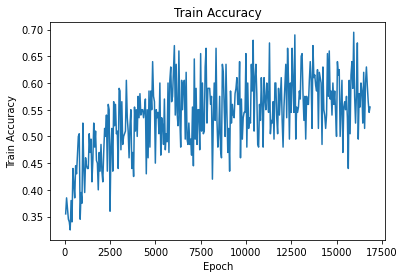

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

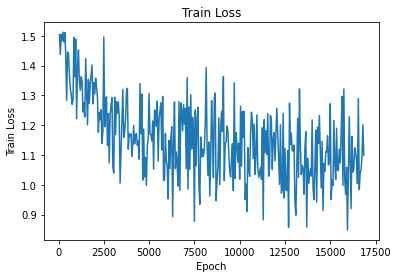

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

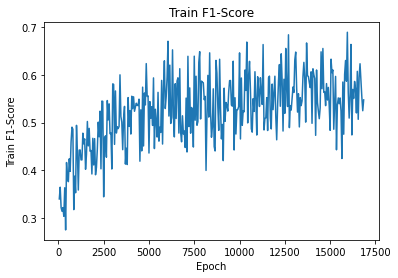

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

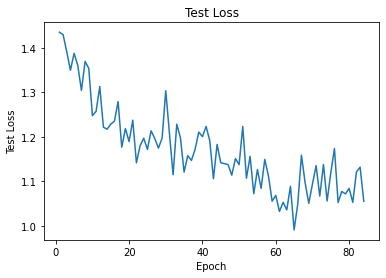

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

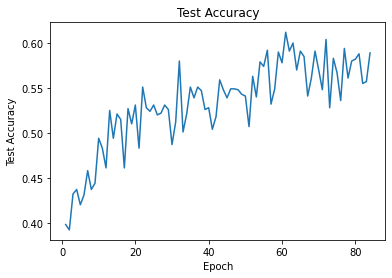

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

### 5 way - 5 shot

In [ ]:
nway = 5
support_samples = 5
query_samples = 10

meta_train_batch = 4
meta_test_batch = 20

outer_epochs = 20000
inner_epochs_train = 5
inner_epochs_test = 10

report_freq = 50
test_freq = 200

inner_lr = 0.01
outer_lr = 0.01

In [ ]:
import copy
metrics_hist = {}
metrics_hist['train'] = []
metrics_hist['test'] = []

for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train = C_train, n_way = nway, N = support_samples * inner_epochs_train, Q = query_samples, meta_batch_size = meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])

    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples*inner_epochs_test, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')


Epoch 50: loss = 1.311996728181839, accuracy = 0.485, f1 = 0.46690430494916985
Epoch 100: loss = 1.304519146680832, accuracy = 0.495, f1 = 0.4805673123559111
Epoch 150: loss = 1.3131476640701294, accuracy = 0.46, f1 = 0.44355443460235494
Epoch 200: loss = 1.1035077422857285, accuracy = 0.555, f1 = 0.5428305420742492
Testing ****** Epoch 200: loss = 1.2637577563524247, acc = 0.49700000000000005, f1 = 0.4889323618338959
Epoch 250: loss = 1.2620845139026642, accuracy = 0.495, f1 = 0.48259927661142493
Epoch 300: loss = 1.0565907806158066, accuracy = 0.55, f1 = 0.5351631888325252
Epoch 350: loss = 1.2210753858089447, accuracy = 0.52, f1 = 0.5031075996773601
Epoch 400: loss = 1.1797227263450623, accuracy = 0.535, f1 = 0.5180163078675062
Testing ****** Epoch 400: loss = 1.1645768880844116, acc = 0.5330000000000001, f1 = 0.5214113912515447
Epoch 450: loss = 1.1431711316108704, accuracy = 0.53, f1 = 0.5219596016659888
Epoch 500: loss = 1.065469965338707, accuracy = 0.5700000000000001, f1 = 0.56

#### results

Text(0.5, 1.0, 'Train Accuracy')

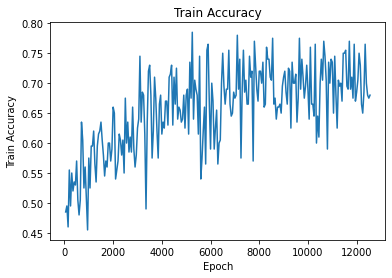

In [ ]:
import numpy as np
meta_train_accuracy_list = [item[1] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_accuracy_list)) + 1)*50, meta_train_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')

Text(0.5, 1.0, 'Train Loss')

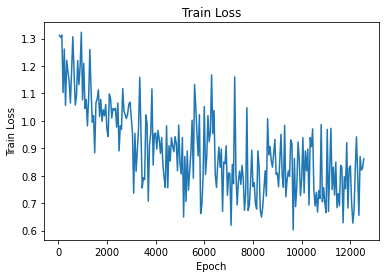

In [ ]:
meta_train_losses_list = [item[0] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_losses_list)) + 1)*50, meta_train_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss')

Text(0.5, 1.0, 'Train F1-Score')

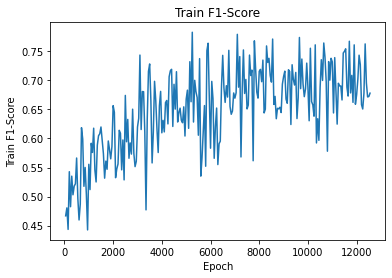

In [ ]:
meta_train_f1_list = [item[2] for item in metrics_hist['train']]
plt.plot((np.arange(len(meta_train_f1_list)) + 1)*50, meta_train_f1_list)
plt.xlabel('Epoch')
plt.ylabel('Train F1-Score')
plt.title('Train F1-Score')

Text(0.5, 1.0, 'Test Loss')

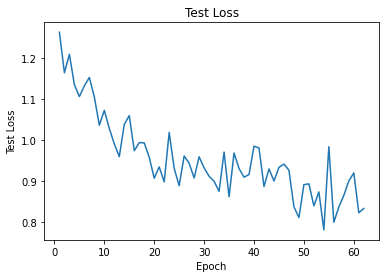

In [ ]:
meta_test_losses_list = [item[0] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_losses_list)) + 1), meta_test_losses_list)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss')

Text(0.5, 1.0, 'Test Accuracy')

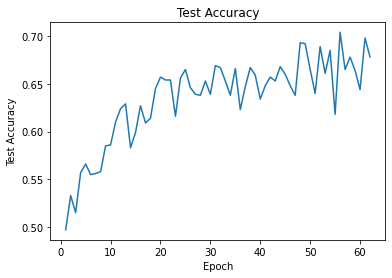

In [ ]:
meta_test_accuracy_list = [item[1] for item in metrics_hist['test']]
plt.plot((np.arange(len(meta_test_accuracy_list)) + 1), meta_test_accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')

## Learning rate schedule

In [ ]:
decay_rate = 0.001

def lr_scheduler(lr, epoch, decay):
    # LearningRate = LearningRate * 1/(1 + decay * epoch)
    return lr * 1/(1 + decay * epoch)

In [ ]:
for epoch in range(1, outer_epochs + 1):
    # create batches of tasks
    tasks = task_batch_creator(C_train=C_train, n_way=nway, N=support_samples, Q=query_samples, meta_batch_size=meta_train_batch)

    inner_model_hist = {}
    inner_model_hist['grads'] = []
    inner_model_hist['losses'] = []
    inner_model_hist['accuracy'] = []
    inner_model_hist['f1'] = []

    for task_idx in range(len(tasks)):
        inner_model = copy.deepcopy(meta_model)
        inner_model.to(device)

        # train the inner model on task
        # returns (loss, grads, accuracy, f1_score)
        tmp = train_inner_model(inner_model, tasks[task_idx], inner_epochs_train, device, inner_lr)

        # save inner model history for training meta model
        inner_model_hist['losses'].append(tmp[0])
        inner_model_hist['grads'].append(tmp[1])
        inner_model_hist['accuracy'].append(tmp[2])
        inner_model_hist['f1'].append(tmp[3])

    # train the model
    tmp = train_meta_model(meta_model, outer_lr, meta_train_batch, device, inner_model_hist['grads'], inner_model_hist['losses'], inner_model_hist['accuracy'], inner_model_hist['f1'])
    meta_model, meta_train_loss, meta_train_accuracy, meta_train_f1 = tmp
    
    # learning rate scheduling
    outer_lr = lr_scheduler(outer_lr, outer_epochs, decay_rate)
    
    # save meta model history for ploting
    metrics_hist['train'].append((meta_train_loss, meta_train_accuracy, meta_train_f1))
    
    if epoch % report_freq == 0:
        print(f'Epoch {epoch}: loss = {meta_train_loss}, accuracy = {meta_train_accuracy}, f1 = {meta_train_f1}')

    if epoch % test_freq == 0:
        tasks = task_batch_creator(C_train=C_test, n_way=nway, N=support_samples, Q=query_samples, batch_size=meta_test_batch)
        test_model_hist = {}
        test_model_hist['losses'] = []
        test_model_hist['accuracy'] = []
        test_model_hist['f1'] = []

        for task_idx in range(len(tasks)):
            test_model = copy.deepcopy(meta_model)
            test_model.to(device)
            tmp = train_inner_model(test_model, tasks[task_idx], inner_epochs_test, device, inner_lr)
            test_model_loss, test_model_acc, test_model_f1 = tmp

            test_model_hist['losses'].append(test_model_loss)
            test_model_hist['accuracy'].append(test_model_acc)
            test_model_hist['f1'].append(test_model_f1)
    
        meta_test_loss = sum(test_model_hist['losses']) / meta_test_batch 
        meta_test_accuracy = sum(test_model_hist['accuracy']) / meta_test_batch
        meta_test_f1 = sum(test_model_hist['f1']) / meta_test_batch
        metrics_hist['test'].append((meta_test_loss, meta_test_accuracy, meta_test_f1))

        print(f'Testing ****** Epoch {epoch}: loss = {meta_test_loss}, acc = {meta_test_accuracy}, f1 = {meta_test_f1}')
